In [1]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from model_temp import OrigamiNetwork

In [2]:
# layer = lambda D, n: D - 2 * np.outer((D@n)/np.dot(n, n), n)
def layer(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    projected = 2 * np.outer(scales, n)
    adjustment = 2*n - projected
    return D + mask[:,np.newaxis] * adjustment

In [3]:
fv1 = .5*np.array([1,1])
fv2 = np.array([-1,1])
fv3 = np.array([-.85,0])

# make a meshgrid of x and y values
x1 = np.linspace(-2,2,20)
x2 = np.linspace(-2,2,20)
X1,X2 = np.meshgrid(x1,x2)

# reshape the meshgrid into a 2D array and concatenate them
X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
pairs = np.concatenate((X1,X2),axis=1)
cut1 = layer(pairs, fv1)
cut2 = layer(cut1, fv2)
cut = layer(cut2, fv3)
Y = cut[:,1] > .6

Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 872.14it/s]


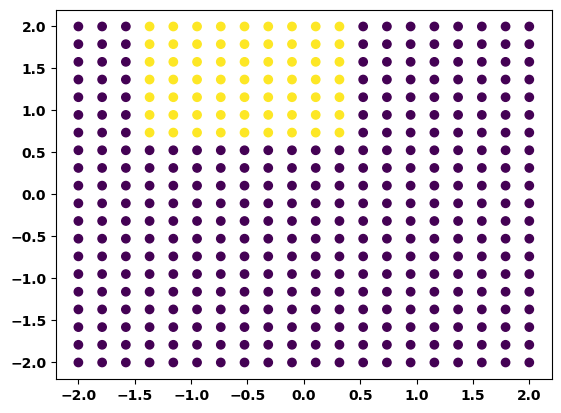

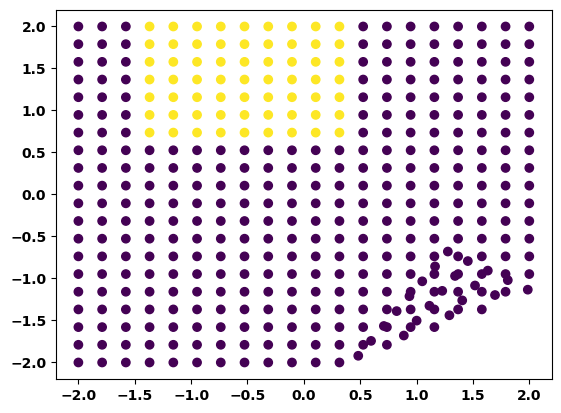

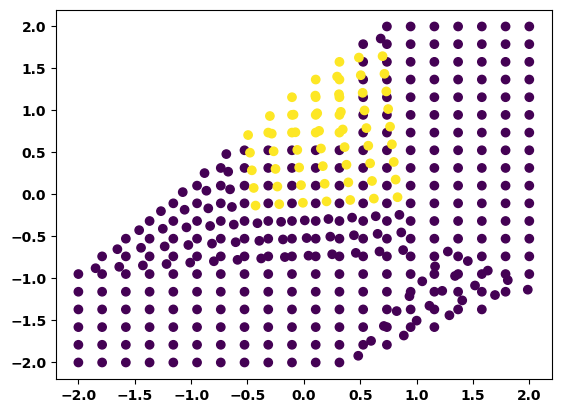

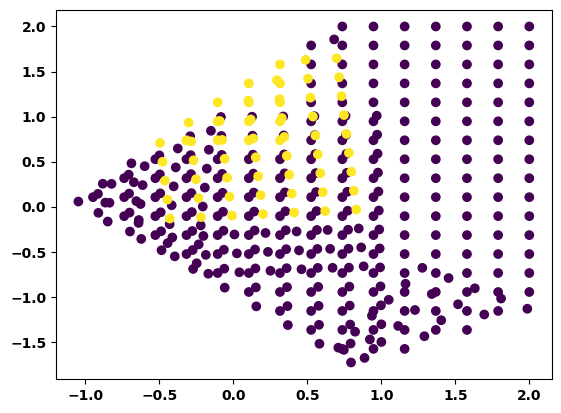

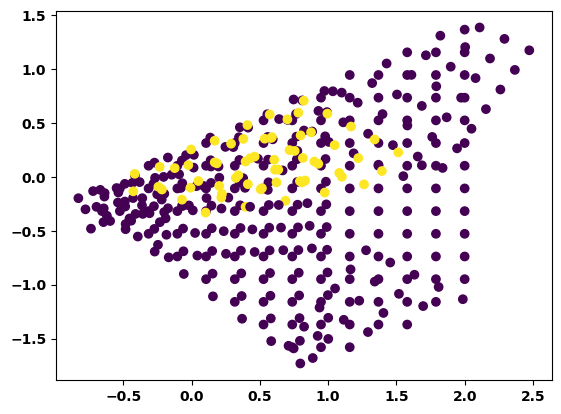

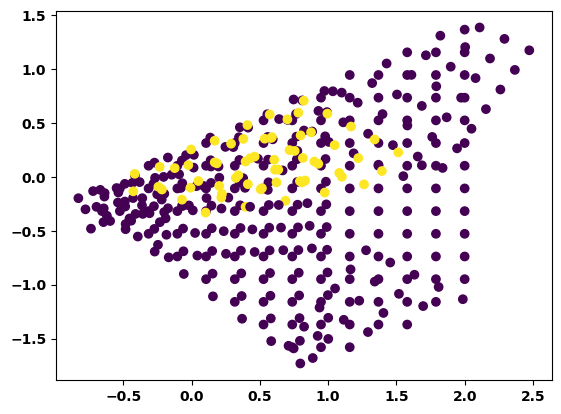

In [4]:
test = OrigamiNetwork(layers = 5, max_iter=1000, learning_rate=0.01, optimizer="grad", batch_size=32, epochs=100, reg=0)
test.fit(pairs, Y)
out = test.forward_pass(pairs)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = Y)
    plt.show()

# test.back_propagation(np.arange(10))
# print(forward)
# print([(i, test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)])
# [test.derivative_fold(forward[i], test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)]

In [5]:
np.array([[1,2,3],[4,5,6],[7,8,9]])[np.array([0,2,2])]

array([[1, 2, 3],
       [7, 8, 9],
       [7, 8, 9]])

In [6]:
# Test case
Z = np.array([[1, 2, 3], [4, 5, 6]])
n = np.array([1, -1/2, 1])
width = len(n)

def derivative_fold(Z, n):
    # Get the scaled inner product, mask, and make the identity stack
    n_normal = n / np.dot(n,n)
    scales = Z@n_normal
    mask = scales > 1
    identity_stack = np.stack([np.eye(width) for _ in range(len(Z))])
    
    # Calculate the first component and a helper term
    first_component = (1 - scales[:,np.newaxis, np.newaxis]) * identity_stack
    helper = 2*Z @ n_normal
    
    # Calculate the outer product of n and helper, then subtract the input
    outer_product = np.outer(helper, n_normal) - Z
    second_component = np.einsum('ij,k->ikj', outer_product, n_normal)
    
    # Return the derivative
    return 2 * mask[:,np.newaxis, np.newaxis] * (first_component + second_component)


result = derivative_fold(Z, n)
print(result)


[[[-0.50205761 -2.30452675 -1.61316872]
  [-0.08230453  0.48559671  0.80658436]
  [ 0.16460905 -2.30452675 -2.27983539]]

 [[-5.58847737 -5.76131687 -2.69958848]
  [ 0.46090535 -1.78600823  1.34979424]
  [-0.9218107  -5.76131687 -7.36625514]]]


In [7]:
x = np.array([1,2,3])
n = np.array([1,-1/2,1])
n_normal = n / np.dot(n,n)

first_comp = np.eye(3)*(1 - x@n_normal)

helper = 2*(x@n_normal)
inner = helper * n_normal - x
second_comp = np.outer(n_normal, inner)
print(2*(first_comp + second_comp))

[[-0.50205761 -2.30452675 -1.61316872]
 [-0.08230453  0.48559671  0.80658436]
 [ 0.16460905 -2.30452675 -2.27983539]]


Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 631.44it/s]


[[-4.9734821  -4.52722019]
 [ 3.40872104 -3.37898779]
 [-0.10706543  0.2435949 ]
 [ 0.03769138  0.22815075]]


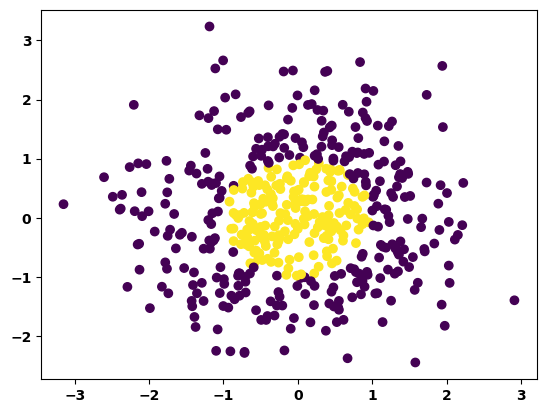

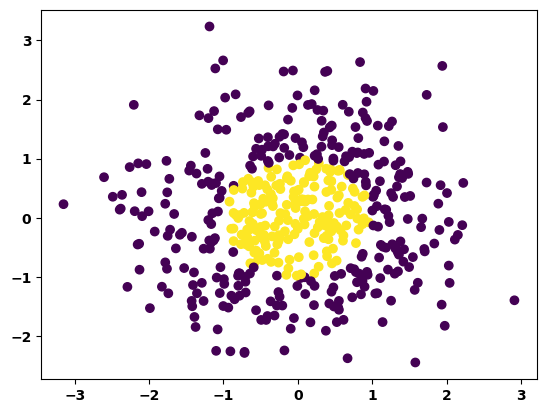

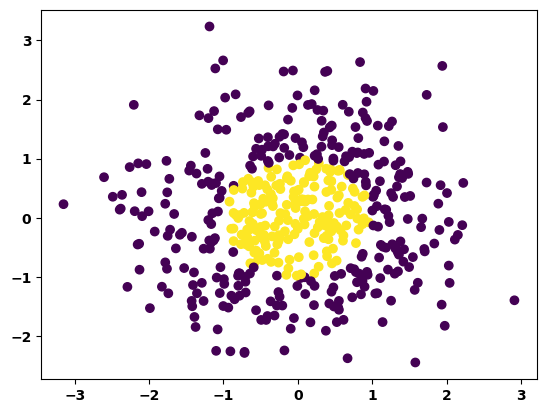

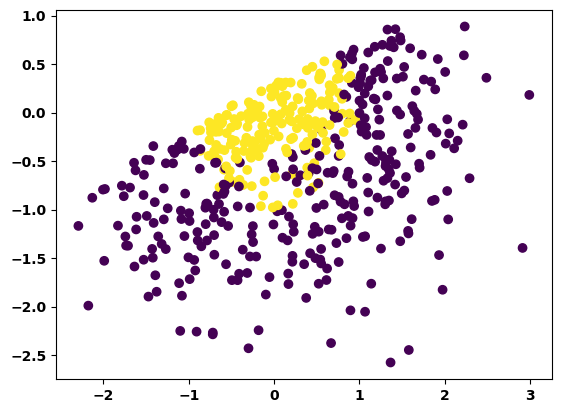

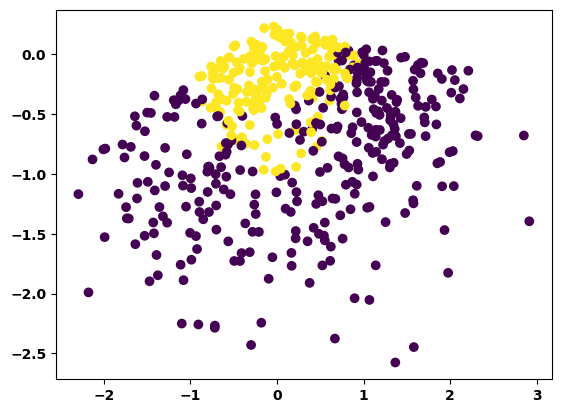

In [8]:
# Set up the model
layers = 4
width = 2
model = OrigamiNetwork(layers=layers, max_iter=1000, learning_rate=0.001)

# Create some dummy data
X = np.random.randn(500, width)
y = np.linalg.norm(X, axis=1) < 1

# # plot the data
# plt.scatter(X[:,0], X[:,1], c=y)
# plt.show()

# Set model parameters
model.fit(X, y)
print(model.fold_vectors)


out = model.forward_pass(X)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = y)
    plt.show()
    

In [9]:
y_hat = model.predict(X)

from sklearn.metrics import accuracy_score
print(accuracy_score(y, y_hat))

0.83


In [10]:
# import small digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# set up the model
model = OrigamiNetwork(layers=3, max_iter=100, learning_rate=0.001)
model.fit(X_train, y_train)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))

Training Progress: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]

0.8666666666666667
